# Text-network Visualization and Analysis

This work is based upon:
(https://gitlab.com/mattiasostmar/discoursebias/blob/master/README.md)

And in the reference article cited in the same README.

Its only a draft, but it's intended to give birth to articles about the content public available of text with the same topics such Buddhism (my aim).

Thus any subsequential working related to these will have it's own place/repository. 

Hope you enjoy this for awhile.

In [234]:
import discoursediversity as did
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

In [237]:
#Auxiliary functions
def partitiontodict(partitions):
  d = dict()
  for idx,cluster in enumerate(partitions.partitions):
    for node in cluster:
      d[partitions.partitions._graph.vs['name'][node]] = idx
  return d

def to_numpy(d):
    for k,v in d.items():
        d[k] = np.array(v)
    return d

# Run on text from file

First we load a file and read it's contents

In [2]:
fileobj = open("tulkutest.txt")
fname = fileobj.name
text = fileobj.read()

Then create a discoursebias Text object, sending in the text and the name of the file as identifier for later use.

In [3]:
experiment = did.TextNetwork(text, fname, stemmer="porter", max_nodes=250, plot=False)

In [ ]:
experiment.stemmed_paras[:10]

In [ ]:
experiment?

In [ ]:
experiment.load_stopwords?

We still haven't started the computing process. In order to do so we must run the aptly named method run() on the Text object. Notice that it returns information about the settings for the experiment and resulting statistical data in a [Pandas Dataframe](https://towardsdatascience.com/pandas-dataframe-a-lightweight-intro-680e3a212b96), so we want to store that in a variable for later use.

tulkutest.txt bias index: FOCUSED
plotting ...


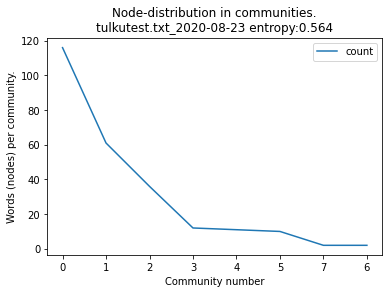

Stored graph as tulkutest.graphml in /home/penalvad/Desktop/discoursediversity/discoursediversity/gexf/.


In [4]:
data = experiment.run()

Now we can look at the data in the returned DataFrame.

In [236]:
data

,tulkutest.txt_2020-08-23
lang,en
nr_stopw,578
no_stops_paras,"[[blazing, splendor, memoirs, dzogchen, yogi],..."
stemmed_paras,"[[blaze, splendor, memoir, dzogchen, yogi], [t..."
stemmedUniqLcW,80233
created_at,2020-08-23 21:47
window,4
topn_nodes,4
topn_comms,4
origNodes,9956


Communities plotting

In [231]:
def community_layout(g, partition):
    """
    Compute the layout for a modular graph.
    
    Arguments:
    ----------
    g -- networkx.Graph or networkx.DiGraph instance
        graph to plot

    partition -- dict mapping int node -> int community
        graph partitions

    Returns:
    --------
    pos -- dict mapping int node -> (float x, float y)
        node positions

    """
    
    

    pos_communities = _position_communities(g, partition, scale=3.)

    pos_nodes = _position_nodes(g, partition, scale=1.)

    # combine positions
    pos = dict()
    for node in g.nodes():
        pos[node] = 2.0*pos_communities[node]+pos_nodes[node]

    return pos

def _position_communities(g, partition, **kwargs):

    # create a weighted graph, in which each node corresponds to a community,
    # and each edge weight to the number of edges between communities
    between_community_edges = _find_between_community_edges(g, partition)

    communities = set(partition.values())
    hypergraph = nx.DiGraph()
    hypergraph.add_nodes_from(communities)
    for (ci, cj), edges in between_community_edges.items():
        hypergraph.add_edge(ci, cj, weight=len(edges))

    # find layout for communities
    pos_communities = nx.spring_layout(hypergraph, weight='weight', **kwargs)

    # set node positions to position of community
    pos = dict()
    for node, community in partition.items():
        pos[node] = pos_communities[community]         

    return pos

def _find_between_community_edges(g, partition):

    edges = dict()

    for (ni, nj) in g.edges():
        ci = partition[ni]
        cj = partition[nj]

        if ci != cj:
            try:
                edges[(ci, cj)] += [(ni, nj)]
            except KeyError:
                edges[(ci, cj)] = [(ni, nj)]

    return edges

def _position_nodes(g, partition, **kwargs):
    """
    Positions nodes within communities.
    """

    communities = dict()
    for node, community in partition.items():
        try:
            communities[community] += [node]
        except KeyError:
            communities[community] = [node]

    pos = dict()
    posspring = dict()
    for ci, nodes in communities.items():
        subgraph = g.subgraph(nodes)
        pos_subgraph = nx.spring_layout(subgraph, weight='weight', **kwargs)        
        pos.update(pos_subgraph)
            
    return pos

def _junctions(textnet):   
  '''
  Extracts nodes inside communities with higher betweeness centrality.
  
  TODO:
  - Extract second highest and third according to given param.
  '''
  junction = dict()
  for com,df in textnet.bc_top_all.groupby('community'):
    name=df.sort_values(['bc_norm'],axis=0,ascending=False)['node'].iloc[0]
    bc=df.sort_values(['bc_norm'],axis=0,ascending=False)['bc_norm'].iloc[0]    
    degree=df.sort_values(['bc_norm'],axis=0,ascending=False)['degree'].iloc[0]
    
    junction[com] = (name,bc,degree)
  return junction

def plot_textnet(textnet):       
    
    plt.figure(figsize=(20,20))
    
    partition=partitiontodict(textnet)
    pos = community_layout(textnet.cutoffUnGraph, partition)    
    
    #Get junctions of communities
    junct = _junctions(textnet)
    
    # New graph to colorize nodes according to community
    node_color=[]    
    node_size=[]
    font_size = dict()
    font_color = dict()
    newgraph = nx.Graph()
    for idx,cor in enumerate(list(textnet.cutoffUnGraph.nodes.items())):
      node_color.append(cor[1]['com'])
      newgraph.add_node(cor[0])
      bc=textnet.bc_top_all.set_index('node').loc[cor[0]]['bc_norm']
      if cor[0]==junct[cor[1]['com']][0]:
        node_size.append(500+bc*1800)
        font_color[cor[0]] = 'red'
        node_color[-1] = node_color[-1] - 0.8
      elif bc*1800 < 200:
        node_size.append(200)
        font_color[cor[0]] = 'black'
      else:
        node_size.append(200+bc*1800)
        font_color[cor[0]] = 'blue'
      font_size[cor[0]]= 25+bc*40
    
    edge_color=[]
    for edge in textnet.cutoffUnGraph.edges.data(): 
      
      if partition[edge[0]] == partition[edge[1]]:
        newgraph.add_edge(edge[0],edge[1])
        edge_color.append((0.0,0.0,0.0,.5))
      elif edge[2]['weight'] < 0.09:
        newgraph.add_edge(edge[0],edge[1])
        edge_color.append((0.5,0.5,0.5,0.08))
        
    # Draw networks
    nx.draw(newgraph, 
            pos, 
            with_label = False,
            node_color=node_color, edge_color=edge_color, 
            node_size=node_size, width=2.0); 
    
    # Plot label with different sizes
    for node, (x, y) in pos.items():
      com=textnet.bc_top_all.set_index('node').loc[node]['community']
      if int(textnet.bc_top_all.set_index('node').loc[node]['degree']) > int(0.8*junct[com][2]):
        plt.text(x, y, node, fontsize=font_size[node], color=font_color[node], ha='center', va='center')
      elif junct[com][0] == node:
        plt.text(x, y, node, fontsize=font_size[node], color=font_color[node], ha='center', va='center')
      else:
        pass
    plt.show()    

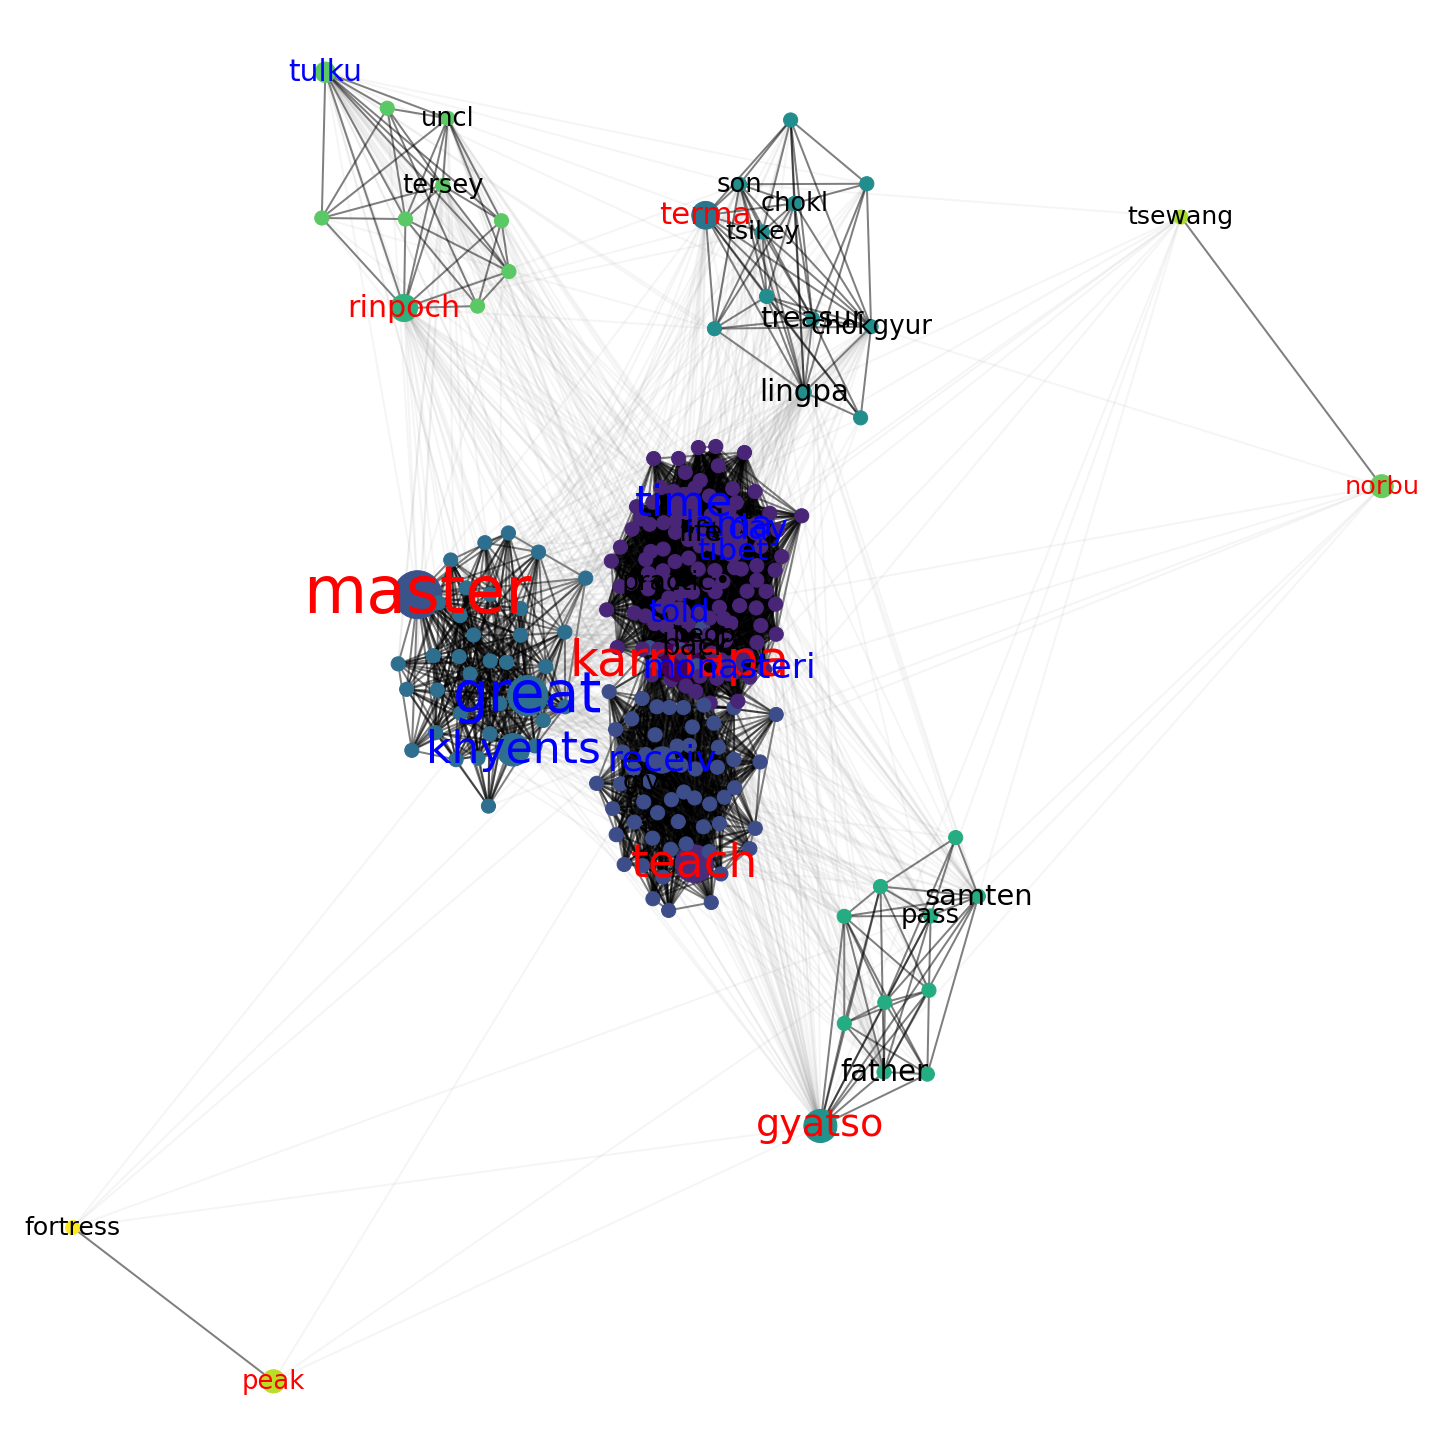

In [233]:
plot_textnet(experiment)

In [216]:
experiment.bc_top_all.set_index('node').loc['ritual']['degree']

98.0

In [49]:
degrees = dict(experiment.finalGraph.degree)

In [54]:
degrees

{'ritual': 98,
 'tsikey': 145,
 'mention': 105,
 'end': 143,
 'paltrul': 77,
 'chokgyur': 188,
 'terton': 158,
 'realiz': 142,
 'nun': 84,
 'walk': 108,
 'thing': 108,
 'mind': 165,
 'invit': 104,
 'derg': 81,
 'lingpa': 200,
 'retreat': 118,
 'left': 122,
 'part': 125,
 'fortress': 85,
 'dilgo': 78,
 'ceremoni': 93,
 'tradit': 126,
 'shri': 82,
 'journey': 76,
 'long': 121,
 'write': 97,
 'state': 97,
 'good': 123,
 'karmey': 95,
 'room': 101,
 'treasur': 169,
 'bodi': 128,
 'happen': 125,
 'ten': 146,
 'kham': 148,
 'practic': 189,
 'bring': 106,
 'close': 107,
 'jewel': 93,
 'dzongsar': 116,
 'gompa': 72,
 'tibet': 198,
 'high': 84,
 'root': 80,
 'buddha': 150,
 'present': 123,
 'rinpoch': 190,
 'import': 147,
 'extrem': 92,
 'return': 113,
 'make': 140,
 'section': 89,
 'peak': 85,
 'bless': 99,
 'nangchen': 134,
 'master': 235,
 'tibetan': 111,
 'mountain': 84,
 'norbu': 131,
 'qualiti': 78,
 'request': 136,
 'read': 108,
 'day': 209,
 'offer': 144,
 'lama': 219,
 'give': 189,
 'a

In [98]:
# Must hack discoursediversity to add degree column to bc_top_all pandas DataFrame

degree = []
for node in experiment.bc_top_all['node']:
  degree.append(degrees[node])
degree=pd.Series(degree,name='degree')
experiment.bc_top_all=pd.concat([experiment.bc_top_all,degree],axis=1)

In [108]:
# Hubs
for com,df in experiment.bc_top_all.groupby('community'):
    print(com)
    print(df.sort_values(['degree'],axis=0,ascending=False))
#experiment.bc_top_all.groupby('community').sort_values(['degree'],axis=1,ascending=False)

0
        node        bc  community   bc_norm  cluster  degree
162     time  0.126506          0  0.462509        1     240
81   karmapa  0.171428          0  0.626743        1     221
64      lama  0.076014          0  0.277908        0     219
62       day  0.055318          0  0.202244        0     209
201    peopl  0.003336          0  0.012196        0     203
..       ...       ...        ...       ...      ...     ...
214    night  0.000000          0  0.000000        0      78
23   journey  0.000259          0  0.000947        0      76
179     hors  0.000000          0  0.000000        0      72
40     gompa  0.000000          0  0.000000        0      72
88    spirit  0.000551          0  0.002013        0      62

[116 rows x 6 columns]
1
          node        bc  community   bc_norm  cluster  degree
119      teach  0.138910          1  0.507859        1     223
211     receiv  0.075657          1  0.276605        0     208
65        give  0.004048          1  0.014801      

In [ ]:
transposed = data.T # Flip X to Y
results = transposed[["modularity","entropy","nodesInTopCom","nodesInGiantCom"]]
results

# Run on a sequence of texts for comparison

We can run the process of reading several files and adding them into a single Pandas DataFrame for analysis.

In [ ]:
import glob
results_list = []

for pathname in glob.glob('texts/sv/*'): # glob allows regex to be run in the filesystem
    text = open(pathname).read()
    filename = pathname.rpartition("/")[2]
    exp = did.TextNetwork(text, filename, stemmer="porter")
    data = exp.run()
    print("----- new experiment ------")
    
    # Now do a little data munging and add the result data for this file
    transp_results = data.T[["modularity","entropyTopFirst","nodesInTopCom","nodesInGiantCom"]]
    results_list.append(transp_results)


## TODO:

1. Text to network - 
- Force Atlas, principais betweenes centrality dos nós das diferentes comunidades, principais nós com maior degree nas comunidades.
   - Falta mudar tamanho dos nós de acordo com bc, force-atlas não ficou bom.
   - Parcial(primeira versão) feito.
   
- Reler análise dos pathways ..., detectar menores caminhos secundários e terciários entre nós juntores (maiores bc) ?, distância dos pathways para os hubs ? 

- vector embedding , text2vec -> correlation matrix - > network ?

2. Gerador de banco de grafos com o pandas e métricas, por número de paragrafos.